In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
basedir = "/pscratch/sd/h/hebina/AbacusLBG/"
import sys, os
from astropy.table import Table, vstack
from astropy.io import fits

for subdir in ["",'ibis_tertiary44/LAE_auto_v2']:
    sys.path.append(basedir+subdir)
from misc import *
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import json
from scipy.special     import erfc

sys.path.append('..')
from mc_forecast import mc_forecast
from forecast_utils import *

In [4]:
from matplotlib.pyplot import rc
rc('mathtext', **{'fontset':'cm'})
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.family"] = "serif"


In [5]:
m_bands = ['M411','M438','M464','M490','M517']
band_z = {
    'M411':[2.26,2.56],
    'M438':[2.47,2.77],
    'M464':[2.68,2.98],
    'M490':[2.89,3.2],
    'M517':[3.1,3.41]
}

In [6]:
cosmo = get_cosmo_P18()
h = cosmo.h()

In [7]:
fint_list = np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/pessimistic_bright.txt')
fint_list += np.loadtxt('/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/fint_v4/optimistic_bright.txt')
fint_list /= 2

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/data_measurements/wR_v4/lae_5bins_bright.json'
data = json.load(open(fn,'r'))

datwt_array = []
for j, band in enumerate(m_bands):
    fint = fint_list[j]    
    datwt_array.append(np.array(data['z%d'%(j+1)]['wt']) / (1-fint)**2)
datwt_array = np.array(datwt_array)

In [8]:
fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/clustering_cat_v4_bright.fits"
# fn = "/global/cfs/cdirs/desi/users/raichoor/laelbg/ibis/analysis/daily-tmp/ibis-xmm-ar-djs-he-rr.fits"
d = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d['RA'],d['DEC'],ra0,dec0)<radius
d = d[coord_cut]

fn = "/pscratch/sd/h/hebina/IBIS/selection_clustering/catalogs/redshift_cat_v4_bright.fits"
# fn = "/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto/ibis-xmm-ar-djs-he-rr.fits"
d_spec = Table.read(fn)
radius = 1.4
ra0,dec0 = 35.75, -4.75
area = 1.4**2 * np.pi
coord_cut = angular_distance(d_spec['RA'],d_spec['DEC'],ra0,dec0)<radius
d_spec = d_spec[coord_cut]

In [9]:
use_mask = True

# $\chi^2$ fits

3637
M411
393 & 383 & 336
pessimistic 0.145
optimistic 0.123
3637
M438
668 & 584 & 506
pessimistic 0.243
optimistic 0.134
M411
area is 6.11, ndensity is 114.7
3821.651678735165 4069.5162007783315
M438
area is 6.11, ndensity is 196.6
3998.3714383710803 4225.927681663755


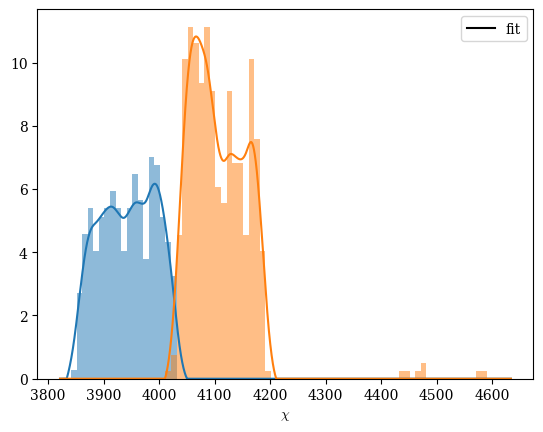

Configuration successfully written to /pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/AbacusSummit_high_c000_ph100/z2.5/ibis_tertiary44_bright_v4/logM_cut_11.00_logM1_12.00_sigma_0.33_kappa_1.00_alpha_0.33_Q_20.00_gamma_1.00_p_max_0.33/configs.json


AssertionError: 

<Figure size 640x480 with 0 Axes>

In [12]:
rbins = np.geomspace(0.4,45,9)[:-1]
RwR = np.sqrt(rbins[1:]*rbins[:-1])
lgMc_list = [11.00,11.25,11.50,11.75,12.0]
# lgMc_list += [11.3,11.4,11.6,11.7,11.8,11.9]
# sigm_list = [.33,.5,.66]#,1.]
alph_list = [.33,.66]#,1.]
sigm_list = [.33,.66]#,1.]
kapp_list = [1]
# plat_list = [5,10,30,100]
plat_list = [10,30,100]

Q_list = [20,100]
gamma_list = [1,5]
pm_list = [.33,.66]
chi2_arr = []
hod_arr = []
r0_arr = []

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/hod/large_grid_ELG_c000_ph100_z2.5_r.json'
lae = json.load(open(fn,"r"))

for lgMcut in lgMc_list:
  for plateau in plat_list:
    lgM1 = lgMcut + np.log10(plateau)
    for alph in alph_list:
      for sigm in sigm_list:
        for kappa in kapp_list:
          for Q in Q_list:
            for gamma in gamma_list:
                for pmax in pm_list:
                  hod_params = {'logM_cut':lgMcut,'logM1':lgM1,'sigma':sigm,'kappa':kappa,'alpha':alph,
                               'Q':Q,'gamma':gamma,'p_max':pmax}           
                  forecast = mc_forecast.initialize('ibis_tertiary44_bright_v4',cosmo,d,d_spec , '../../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                                           band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                                           m_bands=['M411','M438'],zbox=2.5,gal_type='ELG')
                  assert forecast.check_hod_exists()
                  # forecast.make_cat(overwrite=False)
                  # forecast.compute_wR(overwrite=False)
                  c2, tmp1, tmp2, _ = forecast.chi2_wR(datwt_array[:2])
                  hod_arr.append(hod_params)
                  chi2_arr.append(c2)
                  rr = lae['R']
                  for i,samp in enumerate(lae['mocks']):
                      tmp = True
                      for pp in hod_params.keys():
                          ppidx = lae['hodkeys'].index(pp)
                          tmp &= hod_params[pp]==samp['hod'][ppidx]
                      if tmp: break
                  if tmp==False: print(hod_params)
                  xi = np.array(samp['xi0'])
                  r0_arr.append(5*interp1d(rr,xi)(5)**(1/1.8))
                  del lae['mocks'][i]

In [19]:
chi2_arr_z1 = chi2_arr
r0_arr_z1 = r0_arr

In [10]:
rbins = np.geomspace(0.4,45,9)[:-1]
RwR = np.sqrt(rbins[1:]*rbins[:-1])
lgMc_list = [11.00,11.25,11.50,11.75,12.0]
# lgMc_list += [11.3,11.4,11.6,11.7,11.8,11.9]
# sigm_list = [.33,.5,.66]#,1.]
alph_list = [.33,.66]#,1.]
sigm_list = [.33,.66]#,1.]
kapp_list = [1]
# plat_list = [5,10,30,100]
plat_list = [10,30,100]

Q_list = [20,100]
gamma_list = [1,5]
pm_list = [.33,.66]
chi2_arr = []
hod_arr = []
r0_arr = []
fsat_arr = []

fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/hod/large_grid_ELG_c000_ph100_z3.0_r.json'
lae = json.load(open(fn,"r"))

for lgMcut in lgMc_list:
  for plateau in plat_list:
    lgM1 = lgMcut + np.log10(plateau)
    for alph in alph_list:
      for sigm in sigm_list:
        for kappa in kapp_list:
          for Q in Q_list:
            for gamma in gamma_list:
                for pmax in pm_list:
                  hod_params = {'logM_cut':lgMcut,'logM1':lgM1,'sigma':sigm,'kappa':kappa,'alpha':alph,
                               'Q':Q,'gamma':gamma,'p_max':pmax}           
                  forecast = mc_forecast.initialize('ibis_tertiary44_bright_v4',cosmo,d,d_spec , '../ibis_tertiary44_msk.fits',35.75,-4.75, 2.8*np.pi/180,
                                           band_z['M411'][0], band_z['M517'][1], hod_params, use_mask, overwrite=False,ntarg_ratio=1.,fsamp=.6,nbox=256,basedir='..',
                                           m_bands=['M464','M490','M517'],zbox=3.0,gal_type='ELG')
                  assert forecast.check_hod_exists()
                  forecast.make_cat(overwrite=False)
                  forecast.compute_wR(overwrite=False)
                  c2, tmp1, tmp2, _ = forecast.chi2_wR(datwt_array[2:])
                  hod_arr.append(hod_params)
                  chi2_arr.append(c2)
                  rr = lae['R']
                  for i,samp in enumerate(lae['mocks']):
                      tmp = True
                      for pp in hod_params.keys():
                          ppidx = lae['hodkeys'].index(pp)
                          tmp &= hod_params[pp]==samp['hod'][ppidx]
                      if tmp: break
                  if tmp==False: print(hod_params)
                  xi = np.array(samp['xi0'])
                  r0_arr.append(5*interp1d(rr,xi)(5)**(1/1.8))
                  fsat_arr.append(samp['fsat'])
                  del lae['mocks'][i]

wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed
wR already computed


In [11]:
chi2_arr_z2 = chi2_arr
r0_arr_z2 = r0_arr

In [12]:
bestfit_dict = {'z2':{'z':3.0,
                      'r0':r0_arr_z2,
                      'chi2':chi2_arr_z2,
                      'hod':hod_arr,
                      'fsat':fsat_arr,
                     },
               }
import json
with open('r0_arr_ELG.json', 'w') as fp:
    json.dump(bestfit_dict, fp)


In [19]:
r0_arr_z1[np.argmin(chi2_arr_z1)],hod_arr[np.argmin(chi2_arr_z1)]

(2.9801786107693493,
 {'logM_cut': 11.0,
  'logM1': 12.477121254719663,
  'sigma': 0.66,
  'kappa': 1,
  'alpha': 0.66,
  'Q': 20,
  'gamma': 1,
  'p_max': 0.66})

In [13]:
r0_arr_z2[np.argmin(chi2_arr_z2)],hod_arr[np.argmin(chi2_arr_z2)],fsat_arr[np.argmin(chi2_arr_z2)]

(3.9383455303130903,
 {'logM_cut': 11.0,
  'logM1': 12.477121254719663,
  'sigma': 0.33,
  'kappa': 1,
  'alpha': 0.33,
  'Q': 20,
  'gamma': 5,
  'p_max': 0.66},
 0.2640024431555863)

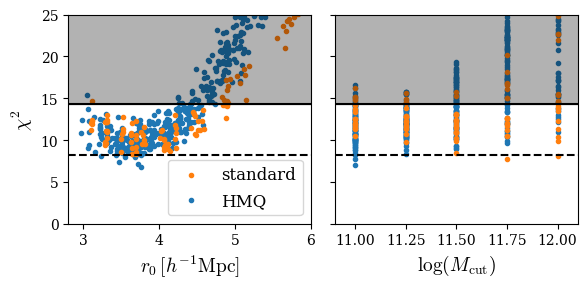

In [58]:
fig,axs = plt.subplots(1,2,figsize=(6,3))
# ax = axs
ax = axs[0]
for i in range(2):
    if i==0: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/ibis_tertiary44/r0_arr_ELG.json'
    else: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/ibis_tertiary44/r0_arr.json'
    dd = json.load(open(fn,'r'))
    ax.scatter(dd['z2']['r0'],dd['z2']['chi2'],marker='.')
    ax.set_xlabel(r'$r_0\,[h^{-1}\text{Mpc}]$',fontsize=14)

ax.set_xlim(2.8,6)
ax.set_ylim(0,25)
# ax.grid(alpha=.8,ls='--')

ax.axhline(8.18,c='k',ls='--')
ax.axhline(14.34,c='k',ls='-')
ax.fill_between(np.linspace(2,7),14.34, 30,color='k',alpha=.3)

ax.set_ylabel(r'$\chi^2$',fontsize=14)
ax.scatter([],[],c='C1',label=r'standard',marker='.')
ax.scatter([],[],c='C0',label=r'HMQ',marker='.')
ax.legend(loc='lower right',fontsize=12)
# ax.set_title(r'wide',y=.01,x=.12)

ax = axs[1]
for i in range(2):
    if i==0: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/ibis_tertiary44_bright/r0_arr_ELG.json'
    else: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/ibis_tertiary44_bright/r0_arr.json'
    dd = json.load(open(fn,'r'))
    ax.scatter([samp['logM_cut'] for samp in dd['z2']['hod']],dd['z2']['chi2'],marker='.')
    # ax.scatter(dd['z2']['r0'],dd['z2']['chi2'],marker='.')
    ax.set_xlabel(r'$\log(M_{\rm cut})$',fontsize=14)

ax.set_xlim(10.9,12.1)
ax.set_ylim(0,25)
# ax.grid(alpha=.8,ls='--')

ax.axhline(8.18,c='k',ls='--')
ax.axhline(14.34,c='k',ls='-')
ax.fill_between(np.linspace(2,20),14.34, 30,color='k',alpha=.3)

# ax.set_ylabel(r'$\chi^2$',fontsize=14)
# ax.scatter([],[],c='C1',label=r'standard',marker='.')
# ax.scatter([],[],c='C0',label=r'HMQ',marker='.')
# ax.legend(loc='lower right',fontsize=12)
# ax.set_title(r'wide',y=.01,x=.12)
ax.set_yticklabels([])


fig.tight_layout()
# fig.savefig('plots/r0_chi2_ELG.pdf')
fig.show()

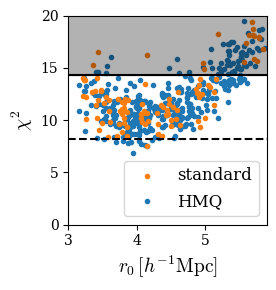

In [10]:
fig,axs = plt.subplots(1,1,figsize=(3,3))
ax = axs
for i in range(2):
    if i==0: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/ibis_tertiary44_bright_v4/r0_arr_ELG.json'
    else: fn = '/pscratch/sd/h/hebina/AbacusLBG/ibis_tertiary44/LAE_auto_v2/mc/ibis_tertiary44_bright_v4.1/r0_arr.json'
    dd = json.load(open(fn,'r'))
    # ax = axs[0]
    ax.scatter(dd['z2']['r0'],dd['z2']['chi2'],marker='.')
    # ax.scatter(dd['z2']['r0'],dd['z2']['chi2'],marker='.')
    ax.set_xlabel(r'$r_0\,[h^{-1}\text{Mpc}]$',fontsize=14)

ax.set_xlim(3.,5.9)
ax.set_ylim(0,20)
# ax.grid(alpha=.8,ls='--')

ax.axhline(8.18,c='k',ls='--')
ax.axhline(14.34,c='k',ls='-')
ax.fill_between(np.linspace(2,7),14.34, 30,color='k',alpha=.3)

ax.set_ylabel(r'$\chi^2$',fontsize=14)
ax.scatter([],[],c='C1',label=r'standard',marker='.')
ax.scatter([],[],c='C0',label=r'HMQ',marker='.')
ax.legend(loc='lower right',fontsize=12)

fig.tight_layout()
fig.savefig('plots/r0_chi2_ELG_bright.pdf')
fig.show()